In [1]:
import sys
sys.path.append('/cellar/users/zkoch/methylation_and_mutation/source_files')
%load_ext autoreload
%aimport mutation_features, methylation_pred, somatic_mut_clock
%autoreload 1
import get_data, utils, mutation_features, methylation_pred, somatic_mut_clock

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import dask.dataframe as dd
from scipy.stats import spearmanr, pearsonr
from scipy import stats
import dask
import sklearn
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
import xgboost as xgb
import shap

%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


# TCGA data

In [3]:
# qnorm data
all_mut_w_age_df, illumina_cpg_locs_df, all_methyl_age_df_t, matrix_qtl_dir, covariate_fn = get_data.read_tcga_data()

reading in data
Got mutations and metadata, reading methylation
Converting Dask df to pandas df, takes ~10min
Got methylation, transposing
Done


# ICGC Data

In [17]:
# qnorm 
icgc_mut_w_age_df, illumina_cpg_locs_df, icgc_methyl_age_df_t, icgc_matrix_qtl_dir, icgc_covariate_fn = get_data.read_icgc_data()

reading in data
Got mutations and metadata, reading methylation
Got methylation, transposing
Done


## Read in soMage results

In [4]:
def create_somage_obj(
    somage_path, 
    directory_glob, 
    file_suffix, 
    mut_feat, 
    illumina_cpg_locs_df, 
    all_methyl_age_df_t,
    out_dir
    ):
    """
    Given a somage path, directory glob, and file suffix, create a somage object from 
    the files in the directory
    """
    print("Creating soMage object", flush = True)
    predicted_methyl_fns = glob.glob(
        os.path.join(somage_path, directory_glob, f"methyl_predictions_{file_suffix}.parquet")
        )
    predicted_perf_fns = glob.glob(
        os.path.join(somage_path, directory_glob, f"prediction_performance_{file_suffix}.parquet")
        )
    trained_model_fns = glob.glob(
        os.path.join(somage_path, directory_glob, f"trained_models_{file_suffix}.pkl")
        )
    feature_mat_fns = glob.glob(
        os.path.join(somage_path, directory_glob, "*features.pkl")
        )
    
    somage = somatic_mut_clock.mutationClock(
            predicted_methyl_fns = predicted_methyl_fns, 
            predicted_perf_fns = predicted_perf_fns,
            all_methyl_age_df_t = all_methyl_age_df_t,
            illumina_cpg_locs_df = illumina_cpg_locs_df,
            output_dir = out_dir,
            train_samples = mut_feat.train_samples,
            test_samples = mut_feat.test_samples,
            tissue_type = "",
            trained_models_fns = trained_model_fns,
            feature_mat_fns = feature_mat_fns,
        )
    return somage

## TCGA

#### Load the data

In [5]:
mut_feat_tcga = mutation_features.mutationFeatures(
    all_mut_w_age_df = all_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
    all_methyl_age_df_t = all_methyl_age_df_t, out_dir = "./", 
    consortium = 'TCGA', dataset = '', cross_val_num = 3,
    matrix_qtl_dir = matrix_qtl_dir,
    covariate_fn = covariate_fn
    )

The least populated class in y has only 2 members, which is less than n_splits=5.


In [25]:
mut_feat_tcga_dict = {}
somage_tcga_dict = {}

for cv_num in [0,1,2,3]:
    mut_feat_tcga = mutation_features.mutationFeatures(
        all_mut_w_age_df = all_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
        all_methyl_age_df_t = all_methyl_age_df_t, out_dir = "./", 
        consortium = 'TCGA', dataset = '', cross_val_num = 0,
        matrix_qtl_dir = matrix_qtl_dir,
        covariate_fn = covariate_fn
    )
    mut_feat_tcga_dict[cv_num] = mut_feat_tcga
    somage_tcga = create_somage_obj(
        somage_path = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_somage_output",
        directory_glob = f"TCGA__500correl_200meqtl_100000nearby_Bothagg_1000numCpGs_*startTopCpGs_500extendAmount_{cv_num}crossValNum",
        file_suffix = "xgboost_nonebaseline_agg_only",
        mut_feat = mut_feat_tcga,
        illumina_cpg_locs_df = illumina_cpg_locs_df,
        all_methyl_age_df_t = all_methyl_age_df_t,
        out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_somage_output"
        )
    # read in pre-comp prediction performance by dset
    somage_tcga.performance_by_dataset_df = pd.read_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_somage_output/pred_methyl_and_perf_by_dset/performance_by_dataset_CV{cv_num}.parquet")
    somage_tcga_dict[cv_num] = somage_tcga
    
    

Creating soMage object


The least populated class in y has only 2 members, which is less than n_splits=5.


Creating soMage object


The least populated class in y has only 2 members, which is less than n_splits=5.


Creating soMage object


The least populated class in y has only 2 members, which is less than n_splits=5.


Creating soMage object


The least populated class in y has only 2 members, which is less than n_splits=5.


In [6]:
cv_num = 3
somage_tcga = create_somage_obj(
    somage_path = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_somage_output",
    directory_glob = f"TCGA__500correl_200meqtl_100000nearby_Bothagg_1000numCpGs_*startTopCpGs_500extendAmount_{cv_num}crossValNum",
    file_suffix = "xgboost_nonebaseline_agg_only",
    mut_feat = mut_feat_tcga,
    illumina_cpg_locs_df = illumina_cpg_locs_df,
    all_methyl_age_df_t = all_methyl_age_df_t,
    out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_somage_output"
    )

# read in pre-comp prediction performance by dset
somage_tcga.performance_by_dataset_df = pd.read_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_somage_output/pred_methyl_and_perf_by_dset/performance_by_dataset_CV{cv_num}.parquet")

Creating soMage object


In [27]:
scrambled_somage_tcga_dict = {}

for cv_num in [0,1,2,3]:

    scrambled_somage_tcga = create_somage_obj(
        somage_path = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_somage_output",
        directory_glob = f"TCGA__500correl_200meqtl_100000nearby_Bothagg_1000numCpGs_*startTopCpGs_500extendAmount_{cv_num}crossValNum",
        file_suffix = "xgboost_scramblebaseline_agg_only",
        mut_feat = mut_feat_tcga_dict[cv_num],
        illumina_cpg_locs_df = illumina_cpg_locs_df,
        all_methyl_age_df_t = all_methyl_age_df_t,
        out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_somage_output"
        )
    # read in pre-comp prediction performance by dset
    scrambled_somage_tcga.performance_by_dataset_df = pd.read_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_somage_output/scrambled_pred_methyl_and_perf_by_dset/performance_by_dataset_CV{cv_num}.parquet")
    scrambled_somage_tcga_dict[cv_num] = scrambled_somage_tcga

Creating soMage object
Creating soMage object
Creating soMage object
Creating soMage object


In [ ]:
somage_tcga_scrambled = create_somage_obj(
    somage_path = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_somage_output",
    directory_glob = f"TCGA__500correl_200meqtl_100000nearby_Bothagg_1000numCpGs_*startTopCpGs_500extendAmount_{cv_num}crossValNum",
    file_suffix = "xgboost_scramblebaseline_agg_only",
    mut_feat = mut_feat_tcga,
    illumina_cpg_locs_df = illumina_cpg_locs_df,
    all_methyl_age_df_t = all_methyl_age_df_t,
    out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_somage_output"
    )
# read in pre-comp prediction performance by dset
somage_tcga_scrambled.performance_by_dataset_df = pd.read_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_somage_output/scrambled_pred_methyl_and_perf_by_dset/performance_by_dataset_CV{cv_num}.parquet")

#### 5C

In [167]:
somage_tcga.performance_by_dataset_df['Model'] = 'soMage'
somage_tcga_scrambled.performance_by_dataset_df['Model'] = 'scrambled-soMage'
combined_perf_df = pd.concat(
    [somage_tcga.performance_by_dataset_df, somage_tcga_scrambled.performance_by_dataset_df]
    ).reset_index(drop=True)


<Axes: xlabel='train_AvP_methyl_pearson', ylabel='Probability'>

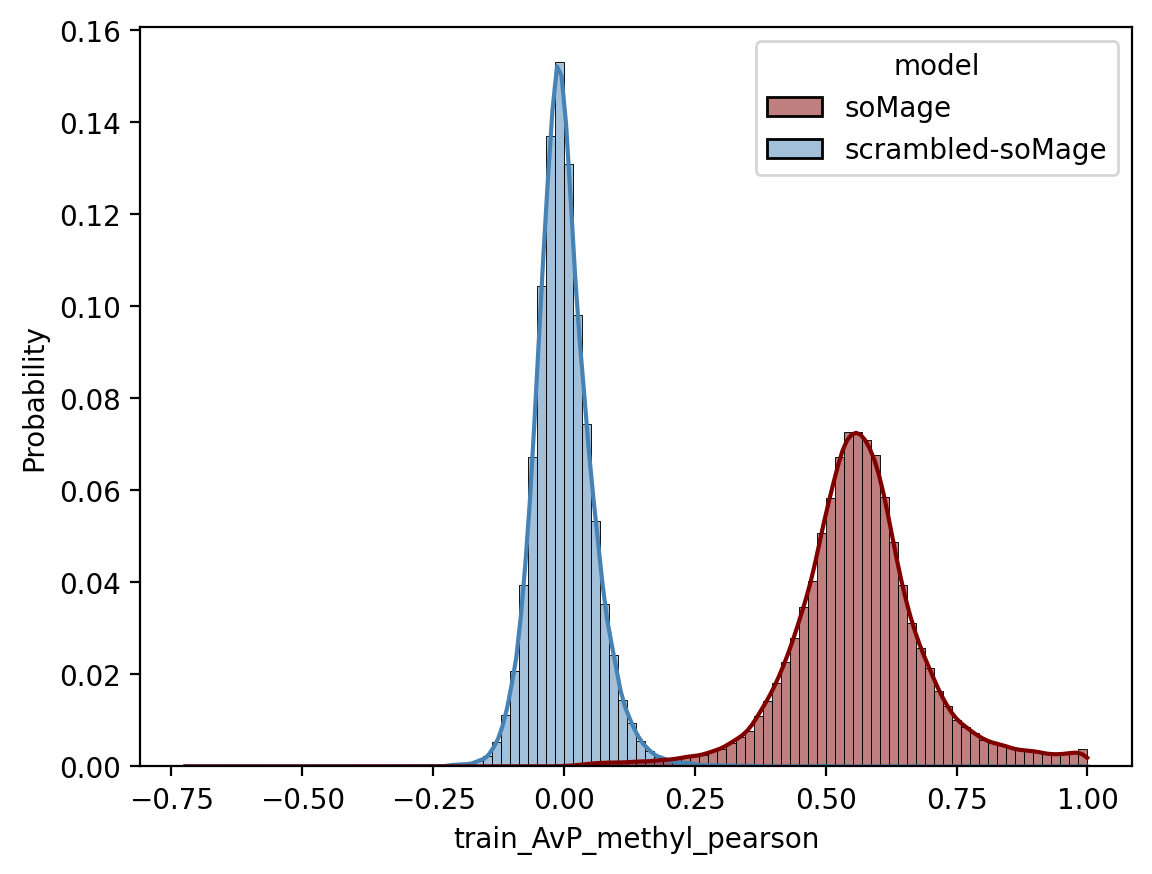

In [29]:
# training set
sns.histplot(
    data = combined_perf_df.query("dataset == 'UCEC'"),
    x = 'train_AvP_methyl_pearson', hue = 'model', bins = 100,
    log_scale=[False,False], stat = 'probability', common_norm=False,
    palette=['maroon', 'steelblue'], kde = True
    )

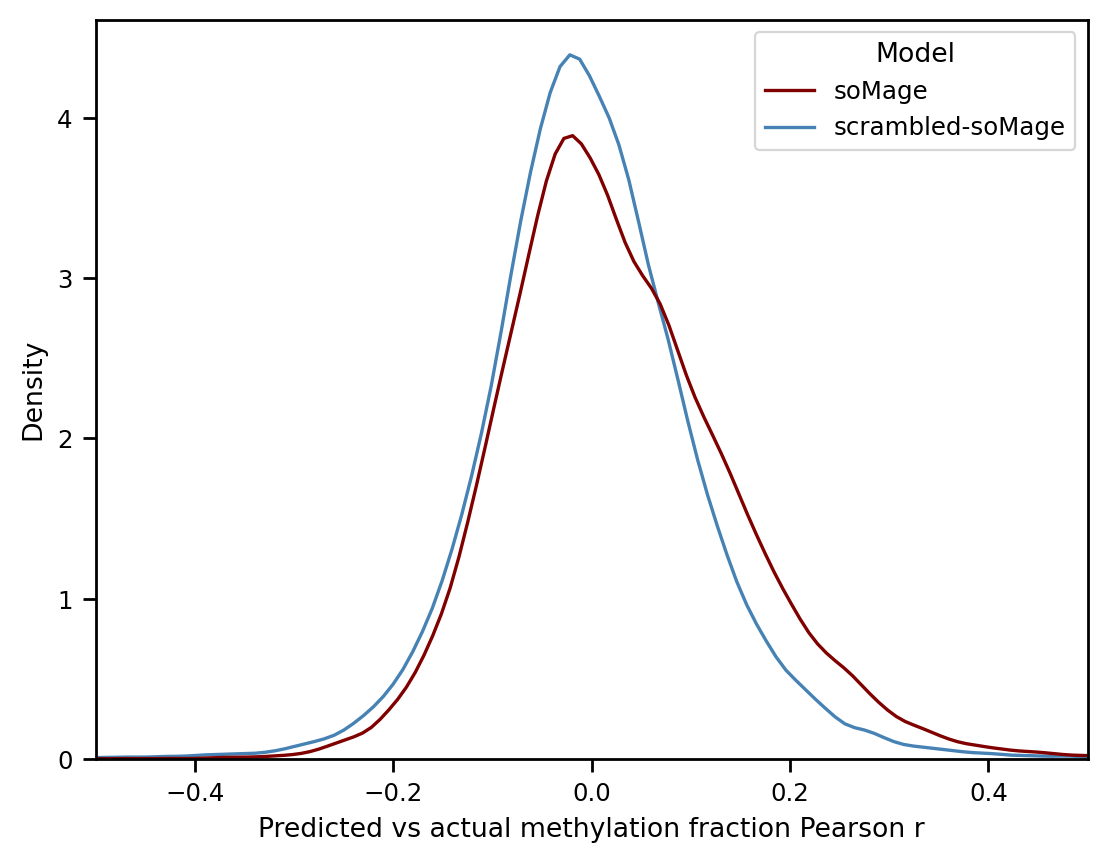

In [168]:
# testing set
sns.kdeplot(
    data = combined_perf_df.query("dataset == 'UCEC'"),
    x = 'AvP_methyl_pearson', hue = 'Model',
    fill=False, common_norm=False,
    palette=['maroon', 'steelblue']
    )
plt.xlabel('Predicted vs actual methylation fraction Pearson r')
plt.xlim(-0.5, .5)
plt.savefig('/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/figure5/figure5C_methyl_pred_perf.svg', dpi=300, format = 'svg')


#### 5B

In [20]:
somage_tcga.performance_by_dataset_df.query("dataset == 'UCEC' and cpg == 'cg09581049'")

,cpg,AvP_methyl_pearson,AvP_methyl_spearman,AvP_methyl_mi,AvP_methyl_mae,Pmethyl_v_Age_pearson_abs,Pmethyl_v_Age_spearman_abs,Pmethyl_v_Age_mi,train_AvP_methyl_pearson,train_AvP_methyl_spearman,train_AvP_methyl_mi,train_Pmethyl_v_Age_spearman_abs,train_Pmethyl_v_Age_mi,train_Amethyl_v_Age_pearson_abs,train_Amethyl_v_Age_spearman_abs,train_Amethyl_v_Age_mi,dataset
561977,cg09581049,0.597503,0.579472,0.047662,0.116198,0.276215,0.283935,0.233289,0.699911,0.695792,0.119982,0.214128,0.102465,0.237564,0.228274,0.109262,UCEC


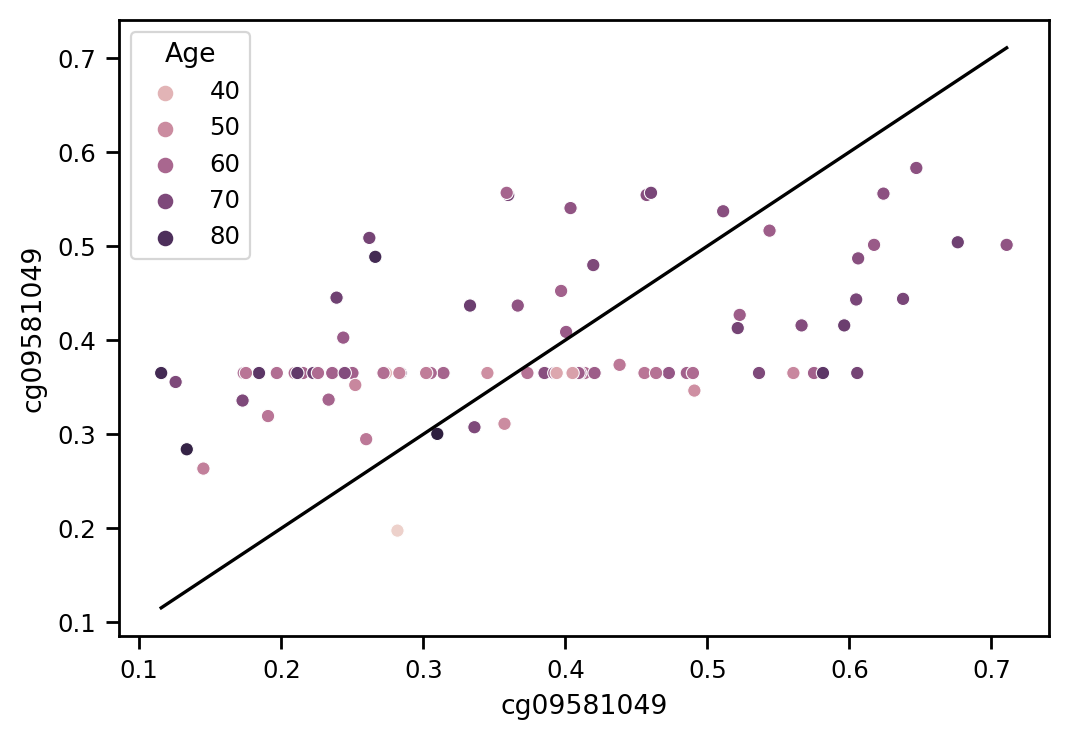

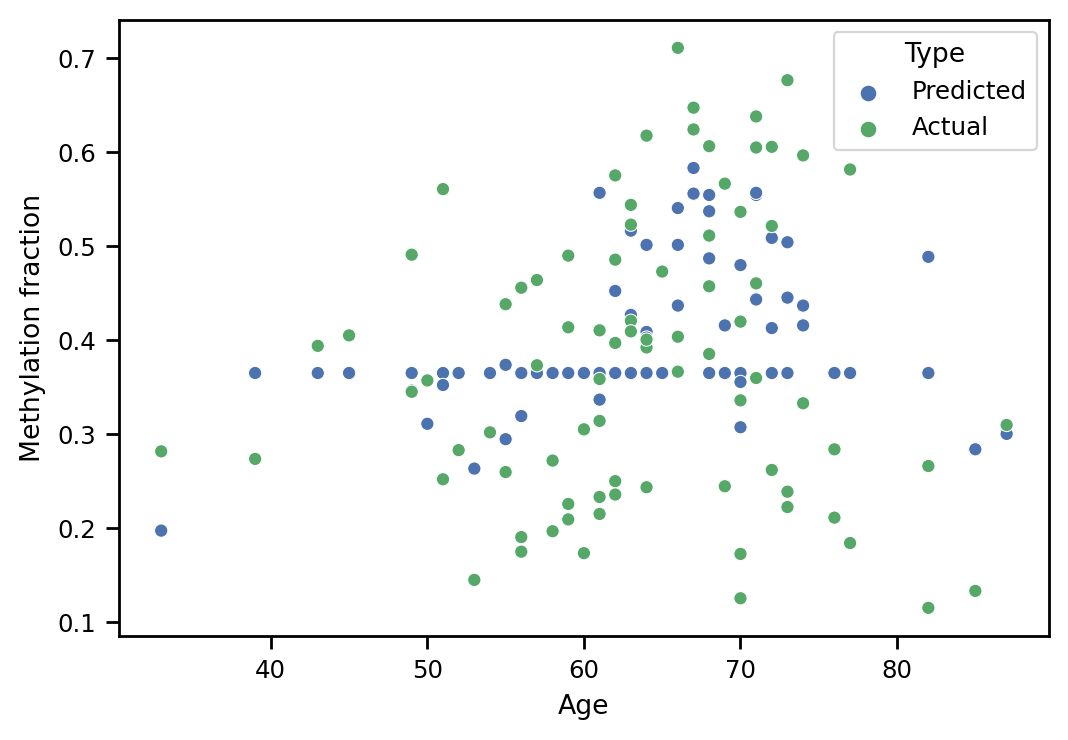

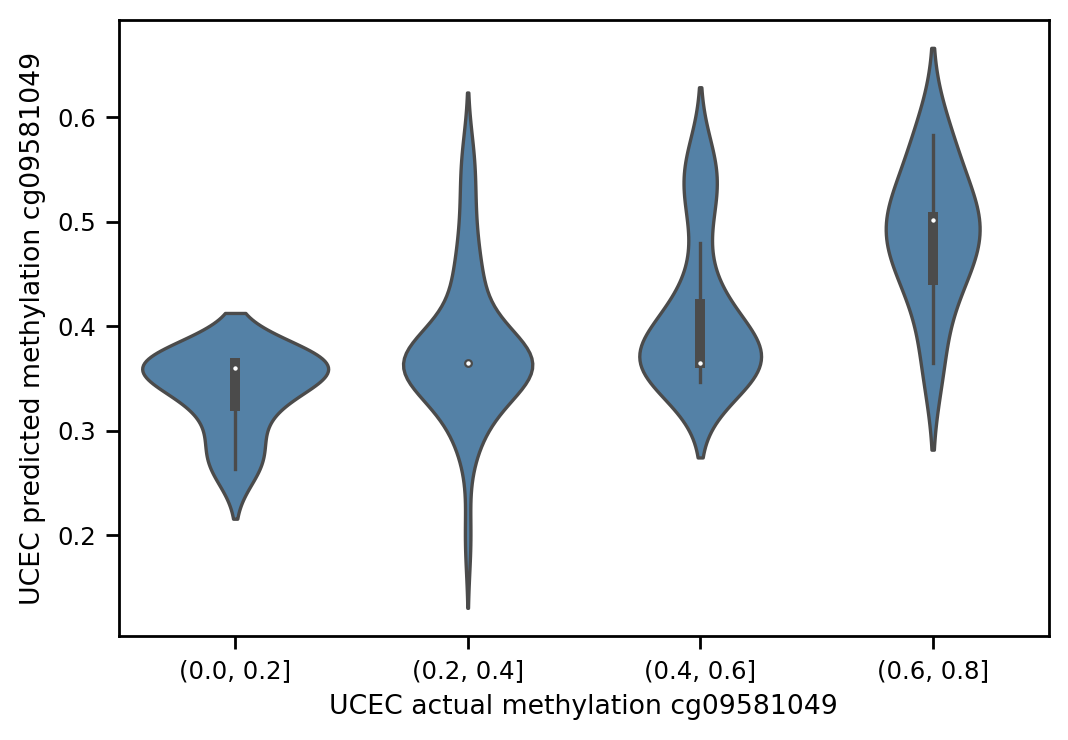

In [169]:
# cpg = 'cg02391549', dataset = 'SKCM',
# cpg = 'cg09581049', dataset = 'UCEC'
somage_tcga.plot_real_vs_predicted_methylation(cpg = 'cg09581049', dataset = 'UCEC', sample_set='test')

#### Train clocks

In [ ]:
best_clock_results = {}
for cv_num in [0,1,2,3]:
    best_clock_results[cv_num] = somage_tcga_dict[cv_num].scan_for_best_clock(
        datasets = somage_tcga_dict[cv_num].performance_by_dataset_df['dataset'].unique().tolist(),
        cpg_choosing_metrics =['train_AvP_methyl_pearson', 'train_Amethyl_v_Age_pearson_abs'],#, 'train_AvP_methyl_mi', 'train_Pmethyl_v_Age_mi'],
        number_of_cpgs = [10, 50, 500, 2500, 10000, 25000],
        training_methylation_types = ['pred', 'actual'],
        train_sets = ['train'],
        model_types = ['xgboost'], # 'elasticnet', 
        train_tissues = ['self']
        )
# write to pickle
fn = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_somage_output/trained_clocks/4_folds_best_clocks.pkl"
with open(fn, 'wb') as f:
    pickle.dump(best_clock_results, f)
    
# combine best_clock_results dict into df
best_clock_results_list = []
for cv_num in [0,1,2,3]:
    best_clock_results[cv_num]['cv_num'] =  cv_num
    best_clock_results_list.append(best_clock_results[cv_num])
best_clock_results_df = pd.concat(best_clock_results_list).reset_index(drop=True)

In [ ]:
scramble_best_clock_results = {}
for cv_num in [0,1,2,3]:
    scramble_best_clock_results[cv_num] = scrambled_somage_tcga_dict[cv_num].scan_for_best_clock(
        datasets = scrambled_somage_tcga_dict[cv_num].performance_by_dataset_df['dataset'].unique().tolist(),
        cpg_choosing_metrics =['train_AvP_methyl_pearson', 'train_Amethyl_v_Age_pearson_abs'],#, 'train_AvP_methyl_mi', 'train_Pmethyl_v_Age_mi'],
        number_of_cpgs = [10, 50, 500, 2500, 10000, 25000],
        training_methylation_types = ['pred', 'actual'],
        train_sets = ['train'],
        model_types = ['xgboost'], # 'elasticnet', 
        train_tissues = ['self']
        )
    
# write to pickle
fn = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_somage_output/trained_clocks/scramble_4_folds_best_clocks.pkl"
with open(fn, 'wb') as f:
    pickle.dump(scramble_best_clock_results, f)
    
# combine best_clock_results dict into df
scramble_best_clock_results_list = []
for cv_num in [0,1,2,3]:
    scramble_best_clock_results[cv_num]['cv_num'] =  cv_num
    scramble_best_clock_results_list.append(scramble_best_clock_results[cv_num])
scramble_best_clock_results_df = pd.concat(scramble_best_clock_results_list).reset_index(drop=True)

In [114]:
# read in actual clock results
# read in all sample model and make predictions
clock_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/new_all_samples_clocks"
real_methyl_models = {}
performances = []
dsets = somage_tcga_dict[cv_num].performance_by_dataset_df['dataset'].unique().tolist()
# read from pickle
for cv_num in [0,1,2]:
    with open(os.path.join(clock_dir, f'epiClock_cv{cv_num}_allSamples.pkl'), 'rb') as f:
        all_sample_model = pickle.load(f)
    real_methyl_models[cv_num] = all_sample_model
    for dataset in dsets:
        # get this cv_num test samples
        test_samples = mut_feat_tcga_dict[cv_num].test_samples
        # and intersect with this datasets samples
        test_samples = list(set(test_samples).intersection(set(all_methyl_age_df_t.query("dataset == @dataset").index.tolist())))
        # make prediction
        predicted_ages = all_sample_model.predict(all_methyl_age_df_t.loc[test_samples].iloc[:, 3:])
        actual_ages = all_methyl_age_df_t.loc[test_samples, 'age_at_index'].values
        pearson = pearsonr(predicted_ages, actual_ages)[0]
        spearman = spearmanr(predicted_ages, actual_ages)[0]
        performances.append({
            'dataset': dataset,
            'cv_num': cv_num,
            'pearson': pearson,
            'spearman': spearman,
            'Model': 'Actual methylation',
            'y_pred': predicted_ages,
            'y_test': actual_ages
            })
actual_performance_df = pd.DataFrame(performances)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<Axes: xlabel='dataset', ylabel='pearson'>

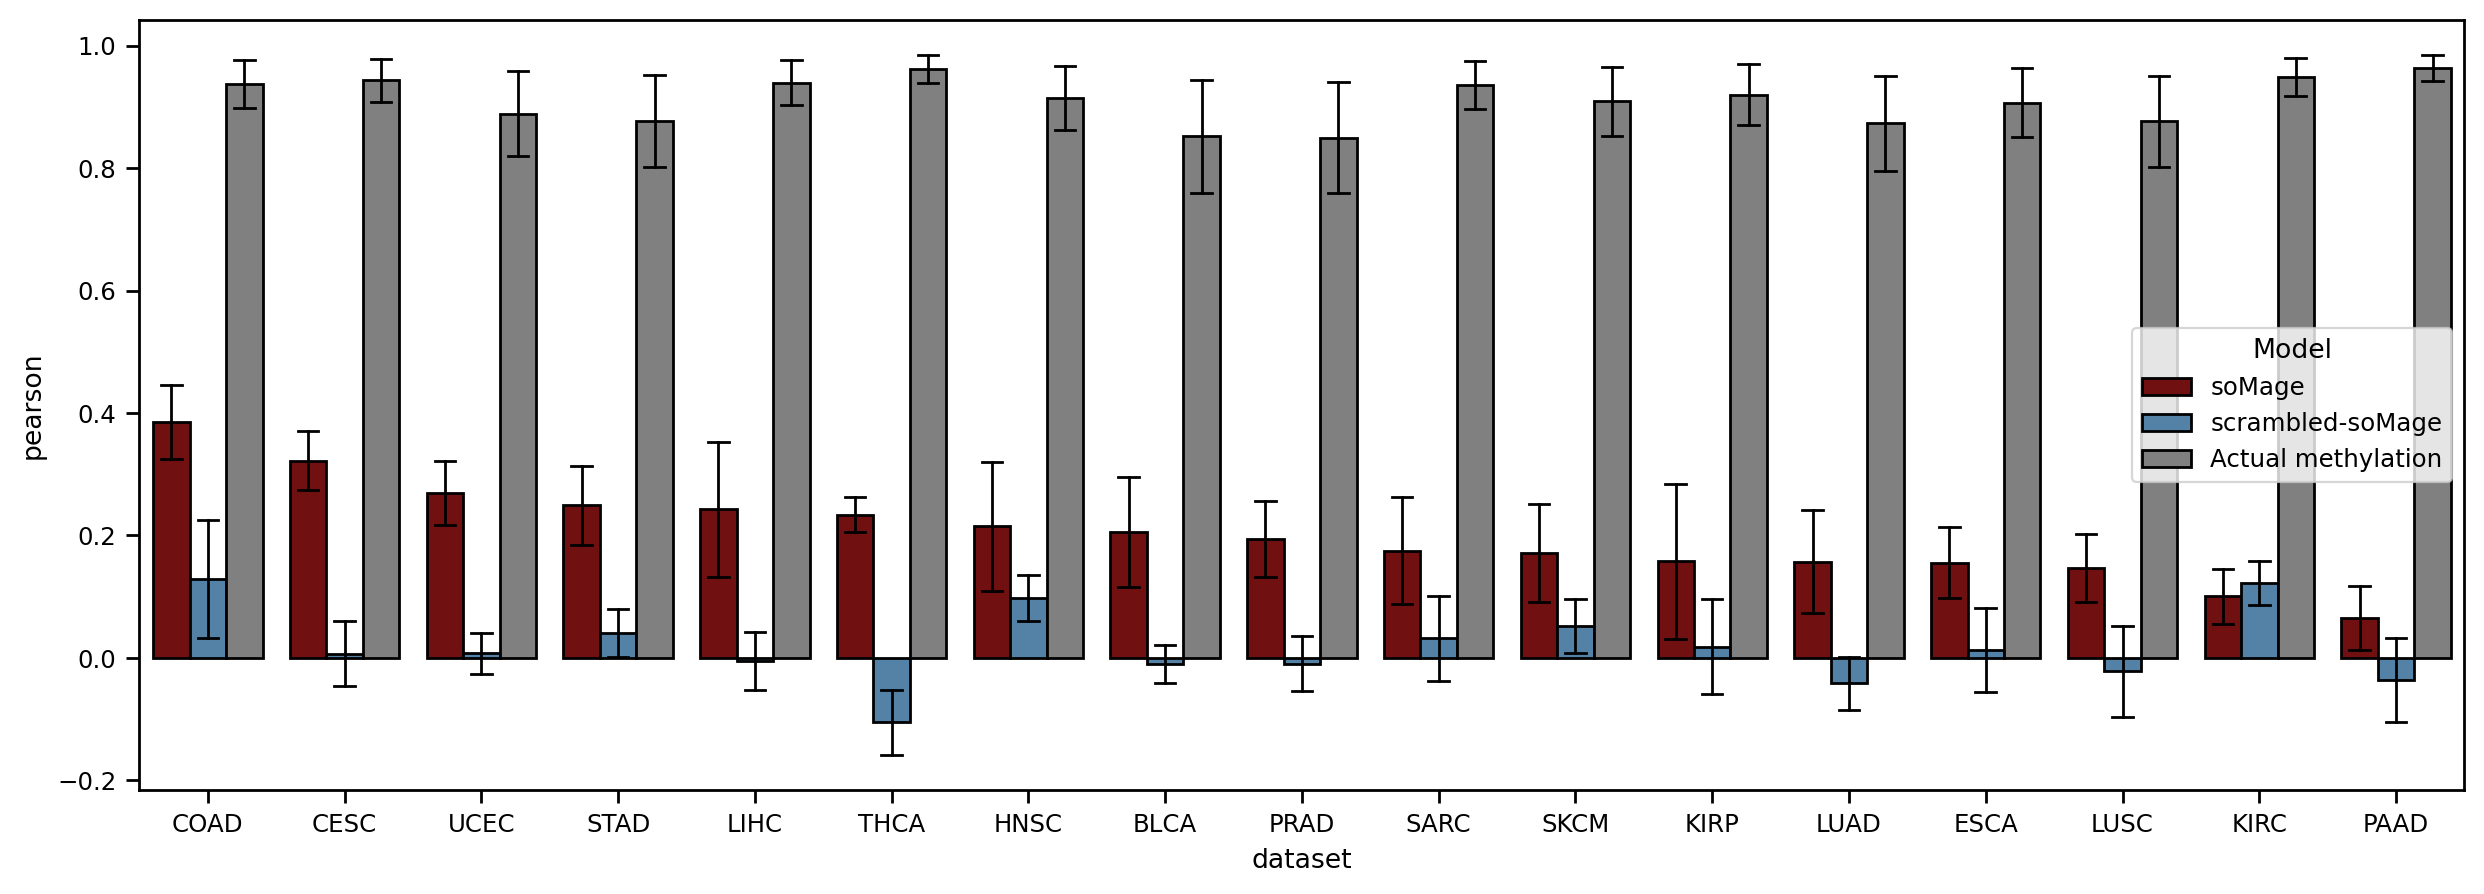

In [116]:
fig, axes = plt.subplots(figsize = (15,5))
sns.set_context('paper')
# get mean value of pearson for each dataset 
filtered_df = best_clock_results_df.query("cpg_choosing_metric == 'train_Amethyl_v_Age_pearson_abs' and training_methylation_type == 'pred' and number_of_cpg == 500")
scramble_filtered_df = scramble_best_clock_results_df.query("cpg_choosing_metric == 'train_Amethyl_v_Age_pearson_abs' and training_methylation_type == 'pred' and number_of_cpg == 500")
# combine 
filtered_df['Model'] = 'soMage'
scramble_filtered_df['Model'] = 'scrambled-soMage'
combined_df = pd.concat(
    [filtered_df, scramble_filtered_df,actual_performance_df, actual_performance_df]
    ).reset_index(drop=True)
order = filtered_df.groupby('dataset')['pearson'].mean().sort_values(ascending=False).index

sns.barplot(
    data=combined_df,  y = 'pearson', x = 'dataset', hue = 'Model',
    ax = axes, errorbar = 'se', capsize=.15, linewidth=1,
    errcolor="black", errwidth=1, order  = order,
    palette = ['maroon', 'steelblue', 'grey'], edgecolor = 'black'
    )
#sns.stripplot(data=filtered_df,  y = 'pearson', x = 'dataset', ax = axes, order = order, color = 'black', alpha = 0.5)

# angle the x labels
#_=plt.xticks(rotation=45, ha='right')

#### 5A: feature matrix and methylation bar

In [9]:
example_cpg = 'cg09581049'

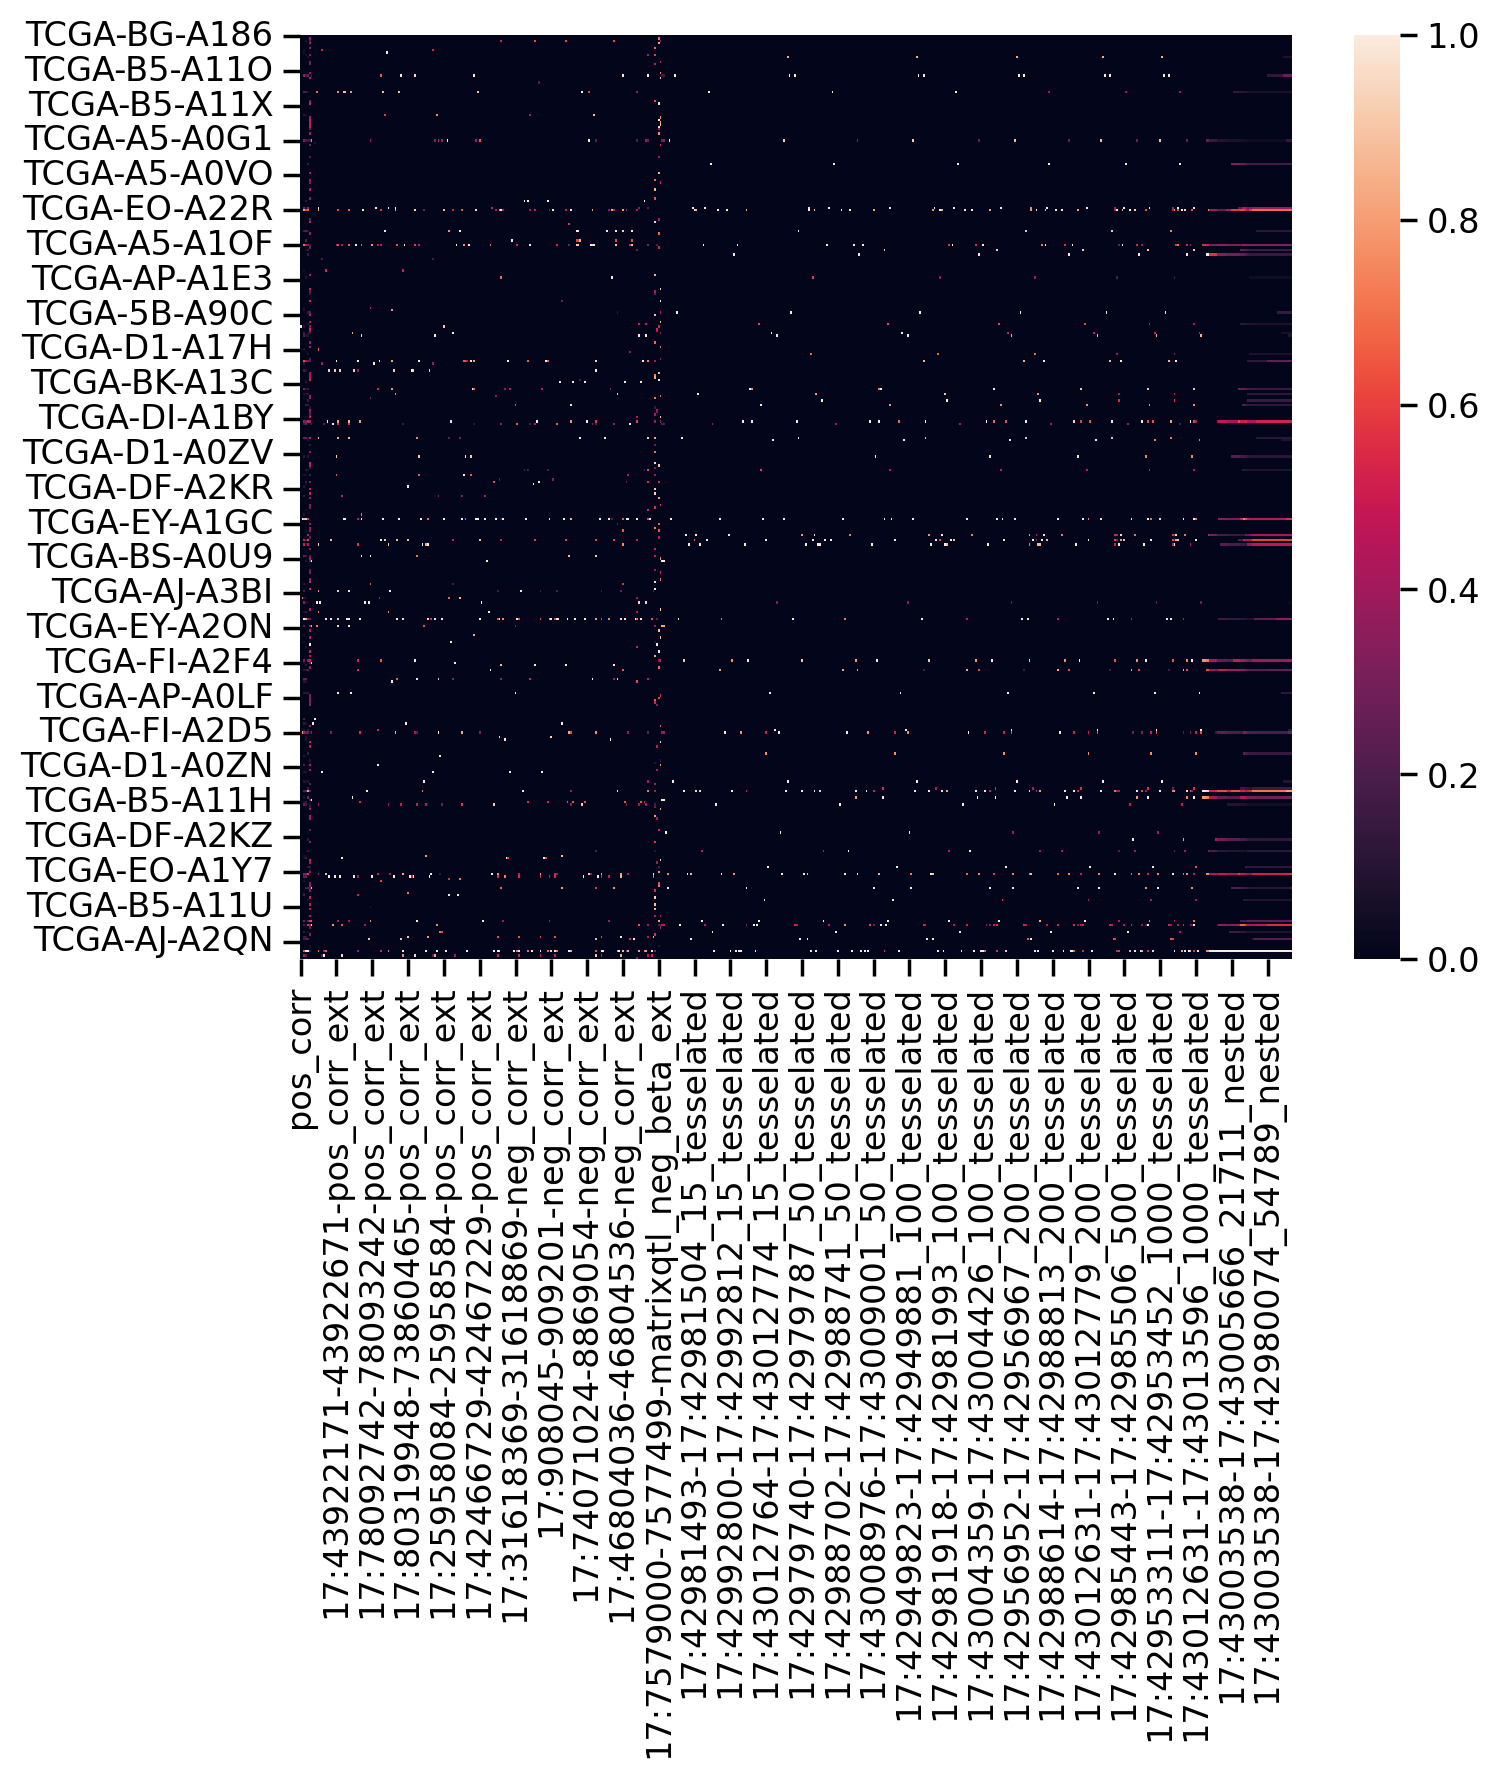

In [10]:
feat_mat = somage_tcga.plot_feature_matrix_heatmap(cpg =example_cpg, dataset = "UCEC", only_agg_feats = True)

In [32]:
feat_mat.to_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/figure5/example_feat_mat_UCEC_cg09581049.parquet')

In [11]:
# also plot example methylation
tp_cpg = all_methyl_age_df_t.query("dataset == 'UCEC'")[example_cpg].values

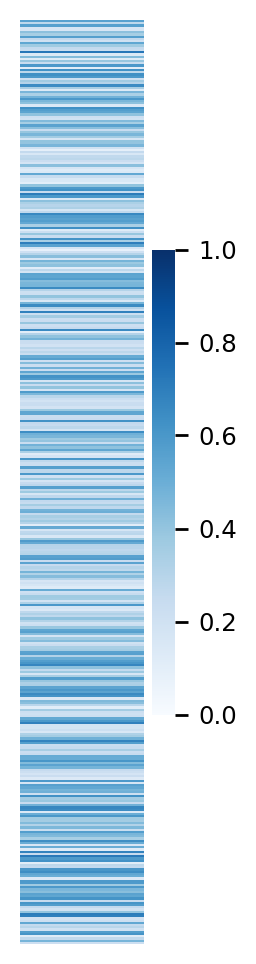

In [19]:
fig, axes = plt.subplots(figsize = (1,6), dpi = 100)
sns.set_context('paper')
sns.heatmap(
    #all_methyl_age_df_t.loc[dataset_train_samples + dataset_test_samples, best_pred_cpgs[9] ].values.reshape(-1,1),
    tp_cpg.reshape(-1,1),
    cmap = 'Blues', ax = axes, vmin=0, vmax=1, cbar=True
    )
plt.xticks([])
plt.yticks([])
plt.savefig('/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/figure5/figure5A_methyl_values.svg', dpi=300, format = 'svg')

#### 5D: example scatterplot

In [86]:
# read in actual clock results 
best_UCEC_clock = pd.read_pickle('/cellar/users/zkoch/methylation_and_mutation/output_dirs/new_all_samples_clocks/epiClock_cv0_UCEC.pkl')

In [89]:
# apply to testing samples from CV 0
test_samples_ucec = set(mut_feat_tcga.test_samples).intersection(set(all_methyl_age_df_t.query("dataset == 'UCEC'").index))


In [93]:
test_methyl_df = all_methyl_age_df_t.loc[test_samples_ucec, :].iloc[:,3:]
# apply clock
pred_ages = best_UCEC_clock.predict(test_methyl_df)

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


In [97]:
pearsonr(pred_ages, best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_test'].values)


PearsonRResult(statistic=0.6044240432174166, pvalue=1.444056052545577e-09)

PearsonRResult(statistic=0.46874162310017137, pvalue=7.845878176824428e-06)

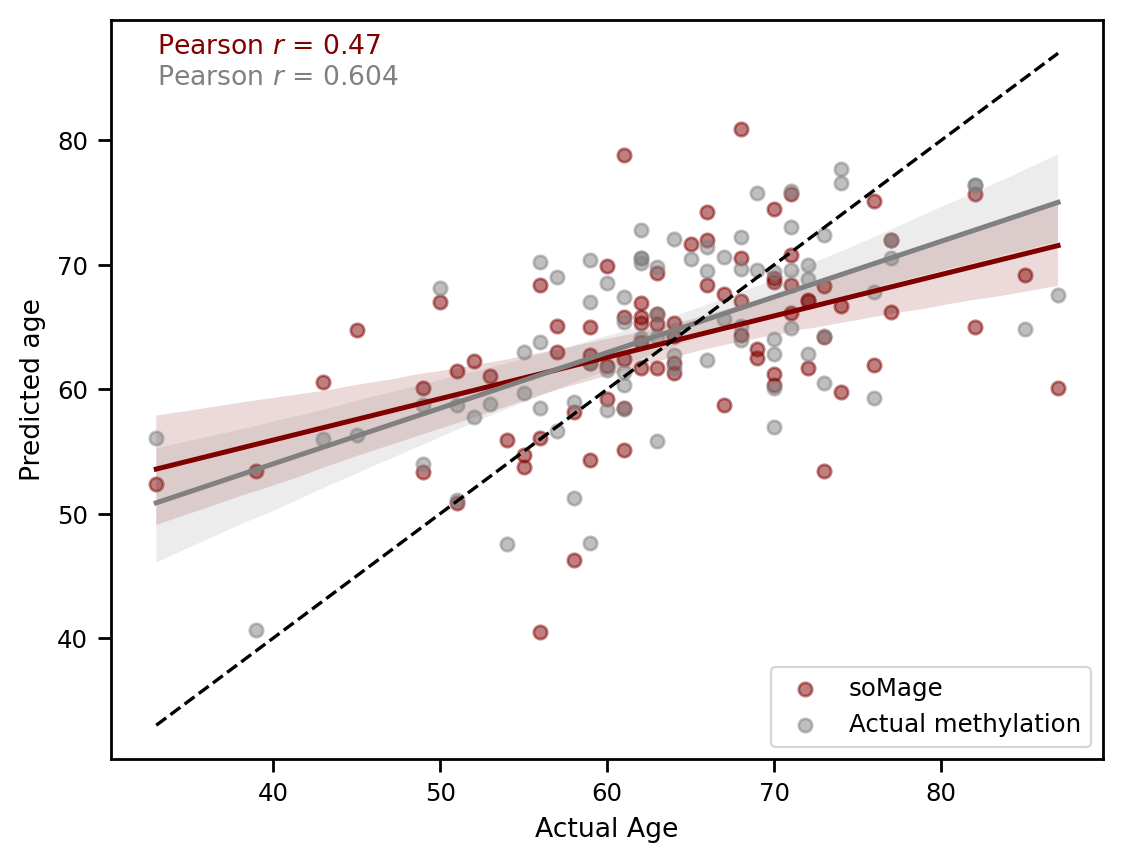

In [172]:
row_num = 278
sns.set_context('paper')
sns.regplot(
    x = best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_test'].values, 
    y = best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_pred'], 
    color = 'maroon', scatter_kws={'alpha':0.5}, label = 'soMage'
    )
somage_pearson_r = round(pearsonr(best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_pred'], best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_test'].values).statistic, 2)

sns.regplot(
    x = best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_test'].values,
    y = pred_ages, 
    color = 'grey', scatter_kws={'alpha':0.5}, label = 'Actual methylation'
    )
actual_methyl_pearson_r = round(pearsonr(pred_ages, best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_test'].values).statistic, 3)
# add soMage pearson r to plot, colored maroon
plt.text(
    x = best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_test'].values.min() + 0.05,
    y = best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_test'].values.max() - 0.05,
    s = r"Pearson $r$ = {}".format(somage_pearson_r),
    color = 'maroon'
    )
plt.text(
    x = best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_test'].values.min() + 0.05,
    y = best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_test'].values.max() - 2.5,
    s = r"Pearson $r$ = {}".format(actual_methyl_pearson_r),
    color = 'grey'
    )
# show legend 
plt.legend( loc='lower right')
#sns.regplot(x = best_clock_scan_results_df_scrambled.loc[15, 'y_test'].values, y = best_clock_scan_results_df_actual.loc[15, 'y_pred'], color = 'red', scatter_kws={'alpha':0.5})
# add y = x line based on min and max of y_test, using axh 
plt.plot(
    [best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_test'].values.min(), best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_test'].values.max()],
    [best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_test'].values.min(), best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_test'].values.max()],
    color = 'black', linestyle = '--',
    )
plt.xlabel('Actual Age')
plt.ylabel('Predicted age')
plt.savefig('/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/figure5/figure5D_soMage_vs_actual_methylation_UCEC.svg', dpi = 300, format = 'svg')

#### 5E: performance barplots

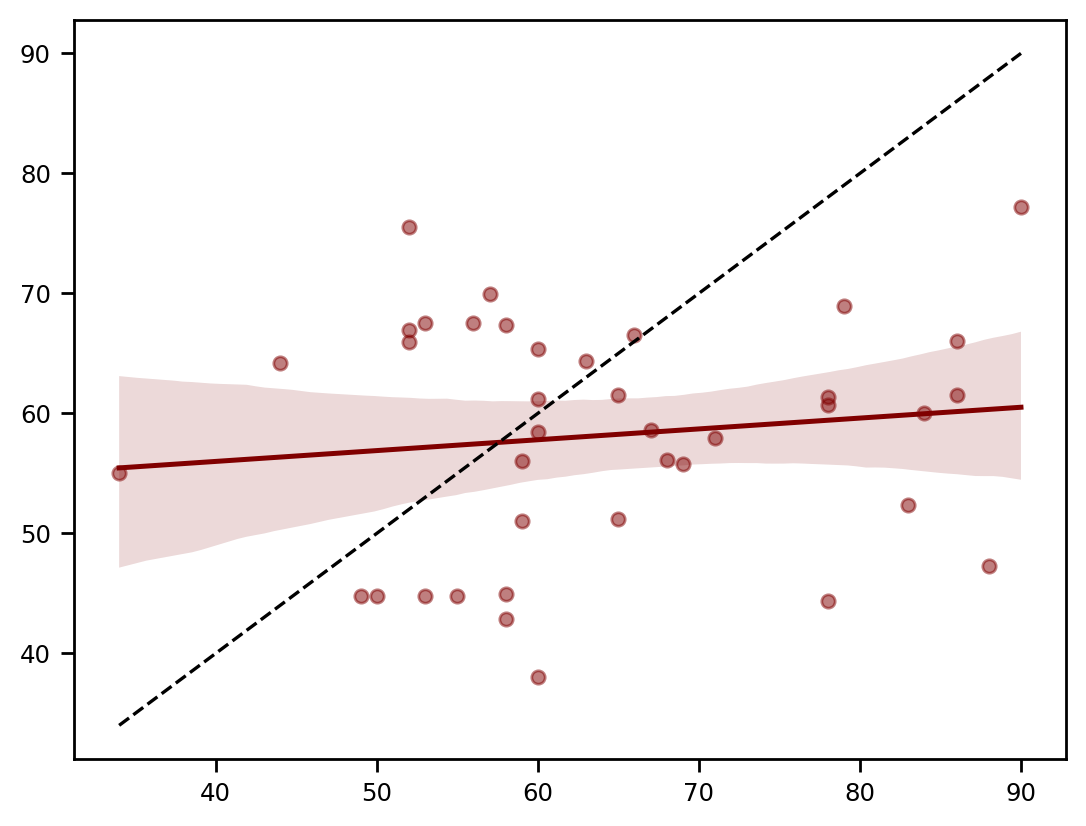

In [146]:
row_num = 710
sns.set_context('paper')
sns.regplot(
    x = best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_test'].values, 
    y = best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_pred'], 
    color = 'maroon', scatter_kws={'alpha':0.5}, label = 'soMage'
    )
plt.plot(
    [best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_test'].values.min(), best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_test'].values.max()],
    [best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_test'].values.min(), best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_test'].values.max()],
    color = 'black', linestyle = '--',
    )

In [141]:
best_clock_scan_results_df_tcga_agg_only.loc[
    (best_clock_scan_results_df_tcga_agg_only['cpg_choosing_metric'] == 'train_Pmethyl_v_Age_mi')
    & (best_clock_scan_results_df_tcga_agg_only['number_of_cpg'] == 50)
    &( best_clock_scan_results_df_tcga_agg_only['training_methylation_type'] == 'pred')
    & (best_clock_scan_results_df_tcga_agg_only['train_set'] == 'train')
    , :].sort_values(by='pearson', ascending = False)

,dataset,cpg_choosing_metric,number_of_cpg,training_methylation_type,train_set,model_type,train_tissue,pearson,spearman,trained_clock,y_pred,y_test
278,UCEC,train_Pmethyl_v_Age_mi,50,pred,train,xgboost,self,0.468742,0.494602,"XGBRegressor(base_score=None, booster=None, ca...","[75.13591, 71.703705, 52.37346, 63.765453, 64....",sample TCGA-BS-A0U5 76 TCGA-EY-A1GO 65 T...
614,COAD,train_Pmethyl_v_Age_mi,50,pred,train,xgboost,self,0.277064,0.248074,"XGBRegressor(base_score=None, booster=None, ca...","[60.977894, 71.36803, 73.69632, 69.64709, 71.2...",sample TCGA-DM-A1D9 67 TCGA-4N-A93T 67 T...
374,STAD,train_Pmethyl_v_Age_mi,50,pred,train,xgboost,self,0.245733,0.252697,"XGBRegressor(base_score=None, booster=None, ca...","[83.7266, 48.24826, 65.99647, 63.492565, 66.16...",sample TCGA-IP-7968 74 TCGA-BR-7716 62 T...
758,PAAD,train_Pmethyl_v_Age_mi,50,pred,train,xgboost,self,0.218456,0.240069,"XGBRegressor(base_score=None, booster=None, ca...","[67.952095, 56.215557, 67.79797, 55.804882, 76...",sample TCGA-PZ-A5RE 44 TCGA-IB-7645 44 T...
518,KIRC,train_Pmethyl_v_Age_mi,50,pred,train,xgboost,self,0.179896,0.189538,"XGBRegressor(base_score=None, booster=None, ca...","[71.56008, 55.85499, 76.763, 48.437107, 62.844...",sample TCGA-CZ-5459 63 TCGA-B0-5120 72 T...
710,SARC,train_Pmethyl_v_Age_mi,50,pred,train,xgboost,self,0.122859,0.058862,"XGBRegressor(base_score=None, booster=None, ca...","[64.36963, 69.97013, 52.387115, 44.77805, 66.9...",sample TCGA-DX-A8BT 63 TCGA-DX-A48U 57 T...
230,LUAD,train_Pmethyl_v_Age_mi,50,pred,train,xgboost,self,0.098987,0.044009,"XGBRegressor(base_score=None, booster=None, ca...","[66.73325, 57.830086, 64.81019, 67.10638, 62.2...",sample TCGA-44-6775 72 TCGA-55-6984 71 T...
326,BLCA,train_Pmethyl_v_Age_mi,50,pred,train,xgboost,self,0.042979,0.066906,"XGBRegressor(base_score=None, booster=None, ca...","[70.52468, 70.15013, 72.74931, 64.11072, 68.91...",sample TCGA-DK-A6B1 67 TCGA-ZF-AA54 71 T...
38,HNSC,train_Pmethyl_v_Age_mi,50,pred,train,xgboost,self,0.036006,0.054410,"XGBRegressor(base_score=None, booster=None, ca...","[72.940346, 58.149105, 65.37611, 61.906376, 57...",sample TCGA-CN-6011 57 TCGA-CR-6493 69 T...
134,PRAD,train_Pmethyl_v_Age_mi,50,pred,train,xgboost,self,0.030053,0.057723,"XGBRegressor(base_score=None, booster=None, ca...","[60.683292, 60.683292, 57.713196, 56.707577, 5...",sample TCGA-HC-A8D1 68 TCGA-G9-6342 61 T...


In [126]:
best_clock_scan_results_df_tcga_agg_only.dtypes

dataset                       object
cpg_choosing_metric           object
number_of_cpg                  int64
training_methylation_type     object
train_set                     object
model_type                    object
train_tissue                  object
pearson                      float64
spearman                     float64
trained_clock                 object
y_pred                        object
y_test                        object
dtype: object

In [117]:
best_clock_scan_results_df_tcga_agg_only.head(2)

,dataset,cpg_choosing_metric,number_of_cpg,training_methylation_type,train_set,model_type,train_tissue,pearson,spearman,trained_clock,y_pred,y_test
278,UCEC,train_Pmethyl_v_Age_mi,50,pred,train,xgboost,self,0.468742,0.494602,"XGBRegressor(base_score=None, booster=None, ca...","[75.13591, 71.703705, 52.37346, 63.765453, 64....",sample TCGA-BS-A0U5 76 TCGA-EY-A1GO 65 T...
271,UCEC,train_AvP_methyl_mi,2500,actual,train,xgboost,self,0.461354,0.177244,"XGBRegressor(base_score=None, booster=None, ca...","[64.15241, 60.51916, 49.555832, 63.72263, 63.2...",sample TCGA-BS-A0U5 76 TCGA-EY-A1GO 65 T...


## ICGC

#### Load the data

In [18]:
mut_feat = mutation_features.mutationFeatures(
    all_mut_w_age_df = icgc_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
    all_methyl_age_df_t = icgc_methyl_age_df_t, out_dir = "./", 
    consortium = 'TCGA', dataset = '', cross_val_num = 0,
    matrix_qtl_dir = icgc_matrix_qtl_dir,
    covariate_fn = icgc_covariate_fn
    )

The least populated class in y has only 1 members, which is less than n_splits=5.


In [51]:
somage = create_somage_obj(
    somage_path = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_somage_output",
    directory_glob = "ICGC__500correl_200meqtl_100000nearby_Bothagg_1000numCpGs_*startTopCpGs_500extendAmount_0crossValNum",
    file_suffix = "xgboost_nonebaseline_agg_only",
    mut_feat = mut_feat,
    illumina_cpg_locs_df = illumina_cpg_locs_df,
    all_methyl_age_df_t = icgc_methyl_age_df_t,
    out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_somage_output"
    )
# read in pre-comp prediction performance by dset
somage.performance_by_dataset_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_somage_output/pred_methyl_and_perf_by_dset/performance_by_dataset_CV0.parquet")

In [52]:
somage_scrambled = create_somage_obj(
    somage_path = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_somage_output",
    directory_glob = "ICGC__500correl_200meqtl_100000nearby_Bothagg_1000numCpGs_*startTopCpGs_500extendAmount_0crossValNum",
    file_suffix = "xgboost_scramblebaseline_agg_only",
    mut_feat = mut_feat,
    illumina_cpg_locs_df = illumina_cpg_locs_df,
    all_methyl_age_df_t = icgc_methyl_age_df_t,
    out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_somage_output"
    )
# read in pre-comp prediction performance by dset
somage_scrambled.performance_by_dataset_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_somage_output/scrambled_pred_methyl_and_perf_by_dset/performance_by_dataset_CV0.parquet")

<Axes: xlabel='dataset', ylabel='AvP_methyl_spearman'>

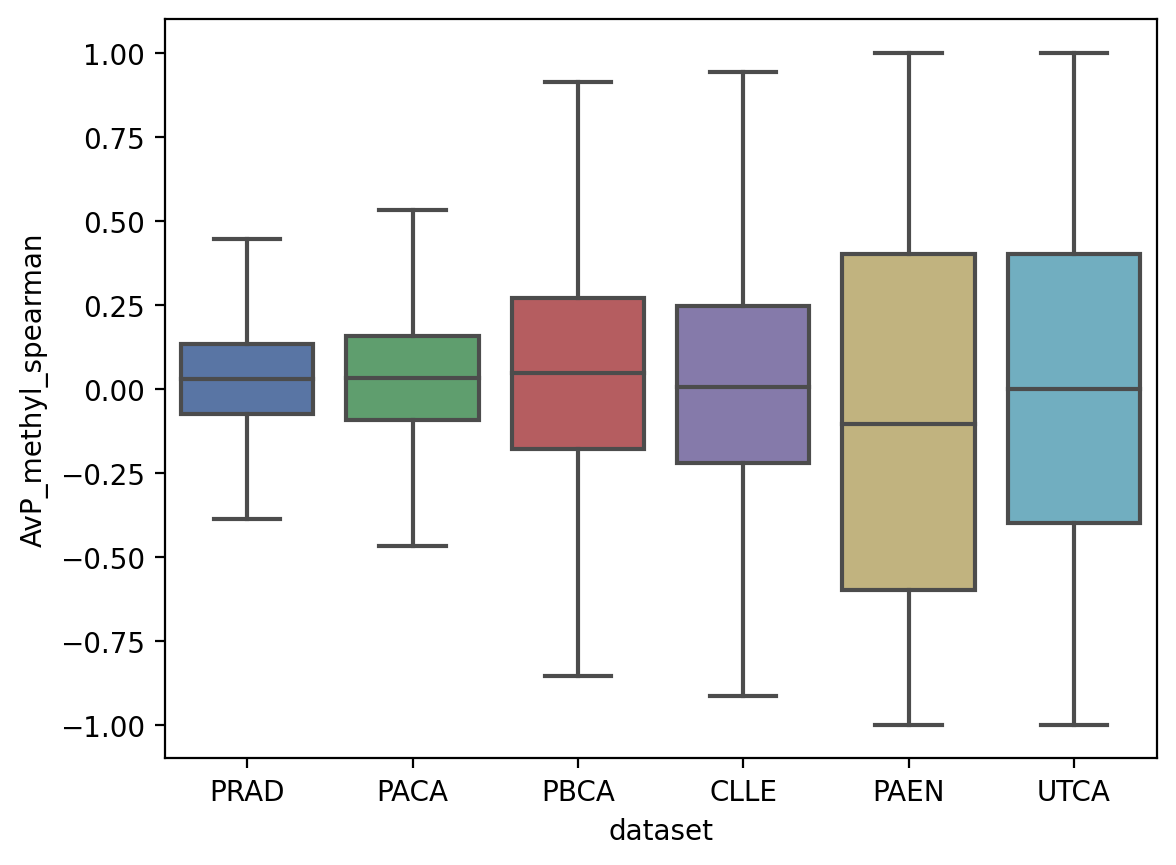

In [7]:
sns.boxplot(data = somage.performance_by_dataset_df, x = 'dataset', y = 'AvP_methyl_spearman', showfliers = False)

#### ICGC Figure 5B

In [60]:
somage.performance_by_dataset_df.query("dataset == 'PRAD'").sort_values(by='AvP_methyl_pearson').tail(10)

,cpg,AvP_methyl_pearson,AvP_methyl_spearman,AvP_methyl_mi,AvP_methyl_mae,Pmethyl_v_Age_pearson_abs,Pmethyl_v_Age_spearman_abs,Pmethyl_v_Age_mi,train_AvP_methyl_pearson,train_AvP_methyl_spearman,train_AvP_methyl_mi,train_Pmethyl_v_Age_spearman_abs,train_Pmethyl_v_Age_mi,train_Amethyl_v_Age_pearson_abs,train_Amethyl_v_Age_spearman_abs,train_Amethyl_v_Age_mi,dataset,model
34790,cg17337086,0.748910,0.212946,0.0,0.013433,0.097471,0.285178,0.0,0.366673,0.440274,0.000000,0.174799,0.000000,0.065986,0.006416,0.000000,PRAD,soMage
24862,cg05694245,0.749886,0.348142,0.0,0.043593,0.110939,0.224773,0.0,0.533230,0.361636,0.025569,0.001531,0.015756,0.223698,0.250843,0.028128,PRAD,soMage
27548,cg02888166,0.760240,0.290230,0.0,0.026711,0.103876,0.181500,0.0,0.677175,0.493920,0.000000,0.144074,0.000000,0.192445,0.216866,0.000000,PRAD,soMage
43634,cg09883131,0.763128,-0.021876,0.0,0.009892,0.055152,0.019892,0.0,0.480839,0.438623,0.000000,0.112975,0.000000,0.021570,0.053784,0.000000,PRAD,soMage
4919,cg12942438,0.771053,0.129130,0.0,0.013008,0.055642,0.129967,0.0,0.581044,0.486100,0.000000,0.128521,0.000000,0.082847,0.056952,0.000000,PRAD,soMage
4561,cg00989323,0.785631,-0.014671,0.0,0.008855,0.067535,0.005213,0.0,0.514283,0.427370,0.000000,0.022347,0.000000,0.150962,0.056251,0.000000,PRAD,soMage
12367,cg21847114,0.787762,0.245782,0.0,0.010759,0.047568,0.143773,0.0,0.520817,0.549155,0.000000,0.022194,0.000000,0.100105,0.048551,0.000000,PRAD,soMage
20962,cg20788561,0.807987,0.097838,0.0,0.015437,0.110966,0.110369,0.0,0.687477,0.397746,0.000000,0.123580,0.000000,0.111353,0.036887,0.000000,PRAD,soMage
47382,cg02242989,0.844876,-0.002416,0.0,0.015337,0.058925,0.000816,0.0,0.810679,0.490662,0.032865,0.154620,0.015756,0.172741,0.162854,0.015756,PRAD,soMage
4875,cg15541371,0.855072,-0.046902,0.0,0.013617,0.162732,0.157329,0.0,0.269688,0.377376,0.000000,0.056760,0.000000,0.093470,0.107763,0.000000,PRAD,soMage


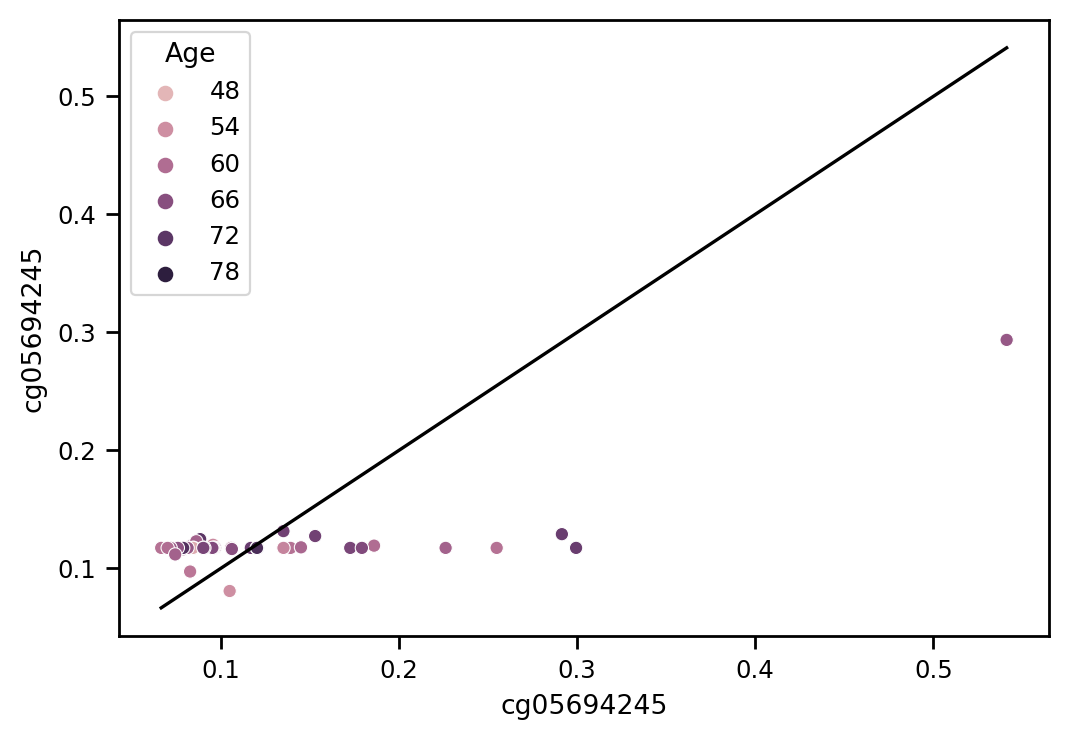

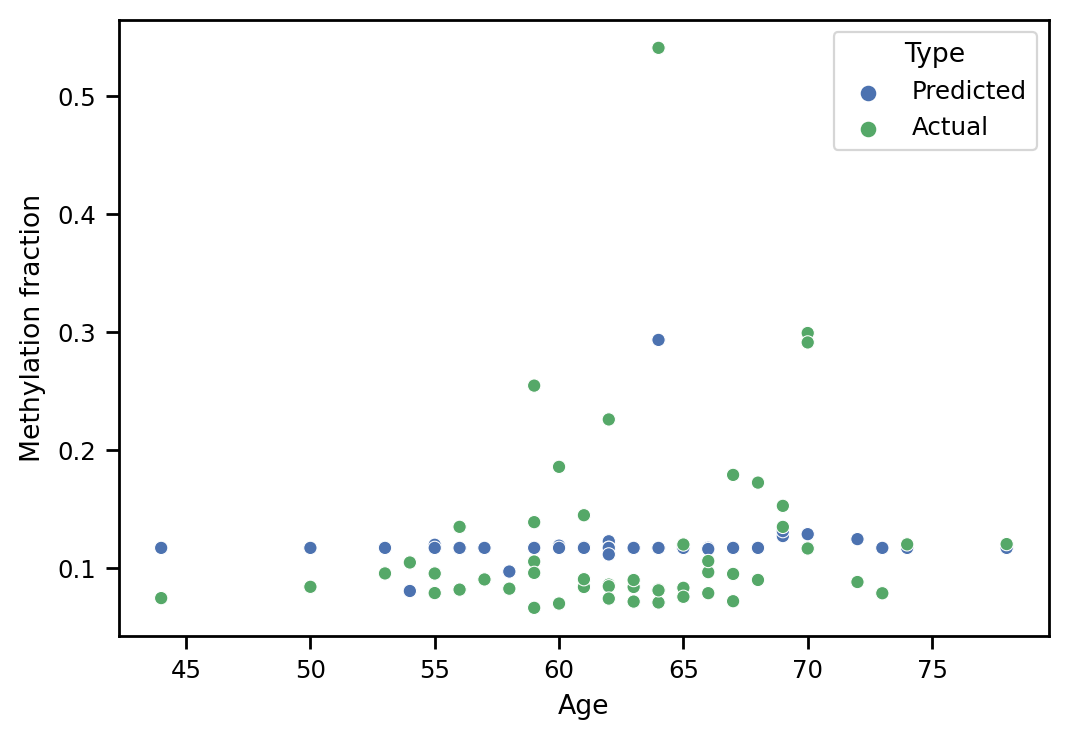

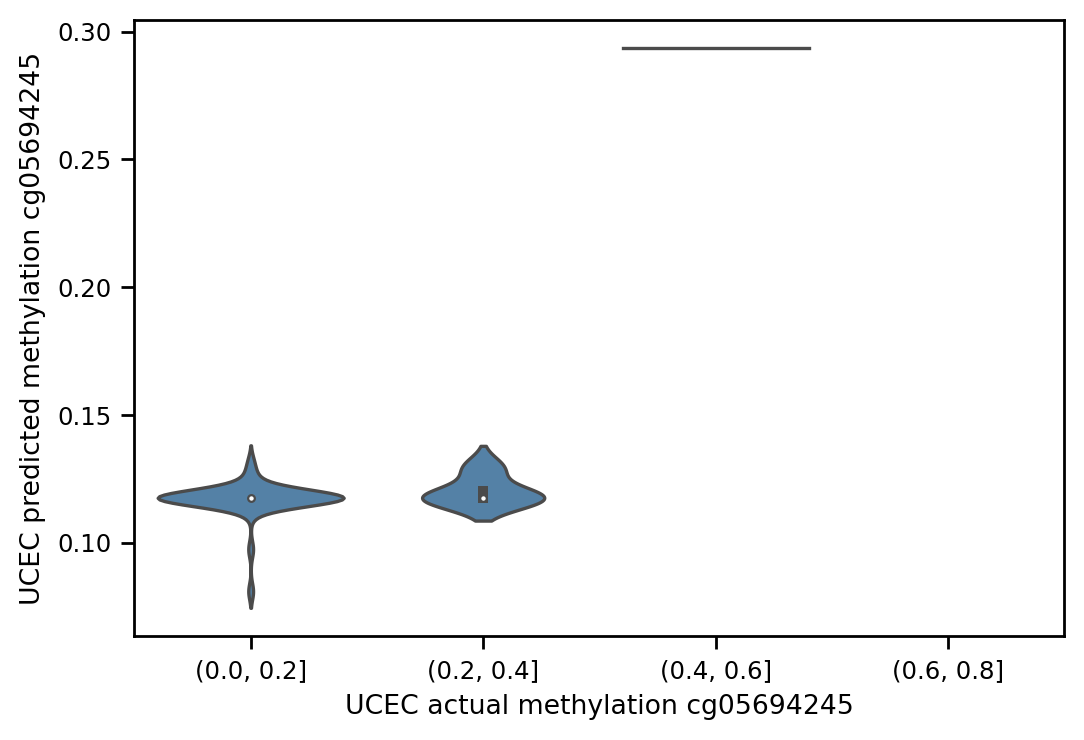

In [62]:
somage.plot_real_vs_predicted_methylation(
    cpg = 'cg05694245', dataset = 'PRAD', sample_set='test'
    )

#### ICGC 5C

In [53]:
somage.performance_by_dataset_df['model'] = 'soMage'
somage_scrambled.performance_by_dataset_df['model'] = 'scrambled-soMage'
combined_perf_df = pd.concat(
    [somage.performance_by_dataset_df, somage_scrambled.performance_by_dataset_df]
    ).reset_index(drop=True)


<Axes: xlabel='train_AvP_methyl_pearson', ylabel='Probability'>

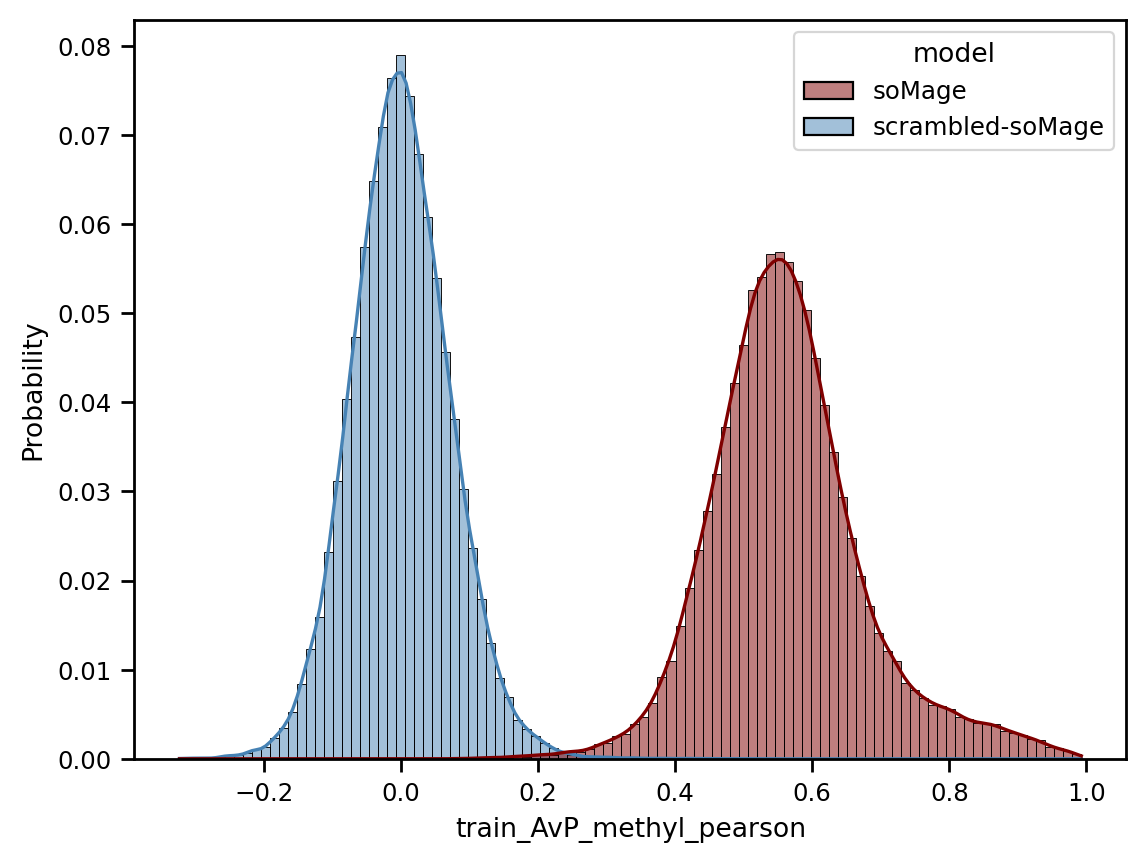

In [54]:
# training set
sns.histplot(
    data = combined_perf_df.query("dataset == 'PRAD'"),
    x = 'train_AvP_methyl_pearson', hue = 'model', bins = 100,
    log_scale=[False,False], stat = 'probability', common_norm=False,
    palette=['maroon', 'steelblue'], kde = True
    )

<Axes: xlabel='AvP_methyl_pearson', ylabel='Probability'>

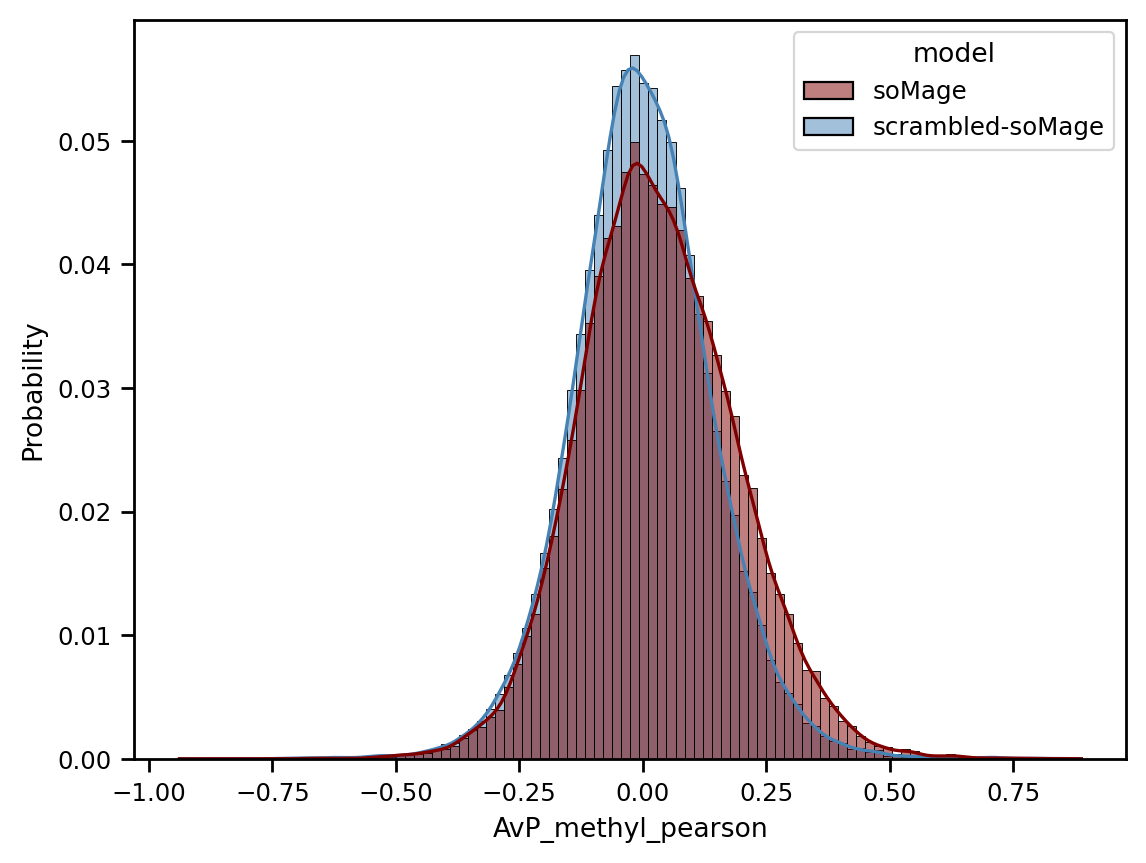

In [55]:
# testing set
sns.histplot(
    data = combined_perf_df.query("dataset == 'PRAD'"),
    x = 'AvP_methyl_pearson', hue = 'model', bins = 100,
    log_scale=[False,False], stat = 'probability', common_norm=False,
    palette=['maroon', 'steelblue'], kde = True
    )

#### Train clocks on predicted methyl

In [ ]:
best_clock_scan_results_df_icgc_agg_only = somage.scan_for_best_clock(
    datasets = somage.performance_by_dataset_df['dataset'].unique().tolist(),
    cpg_choosing_metrics =['train_AvP_methyl_spearman', 'train_Pmethyl_v_Age_spearman_abs', 'train_AvP_methyl_mi', 'train_Pmethyl_v_Age_mi'],
    number_of_cpgs = [10, 50, 500, 2500, 10000, 25000],
    training_methylation_types = ['pred', 'actual'],
    train_sets = ['train'],
    model_types = ['xgboost'], # 'elasticnet', 
    train_tissues = ['self']
    )

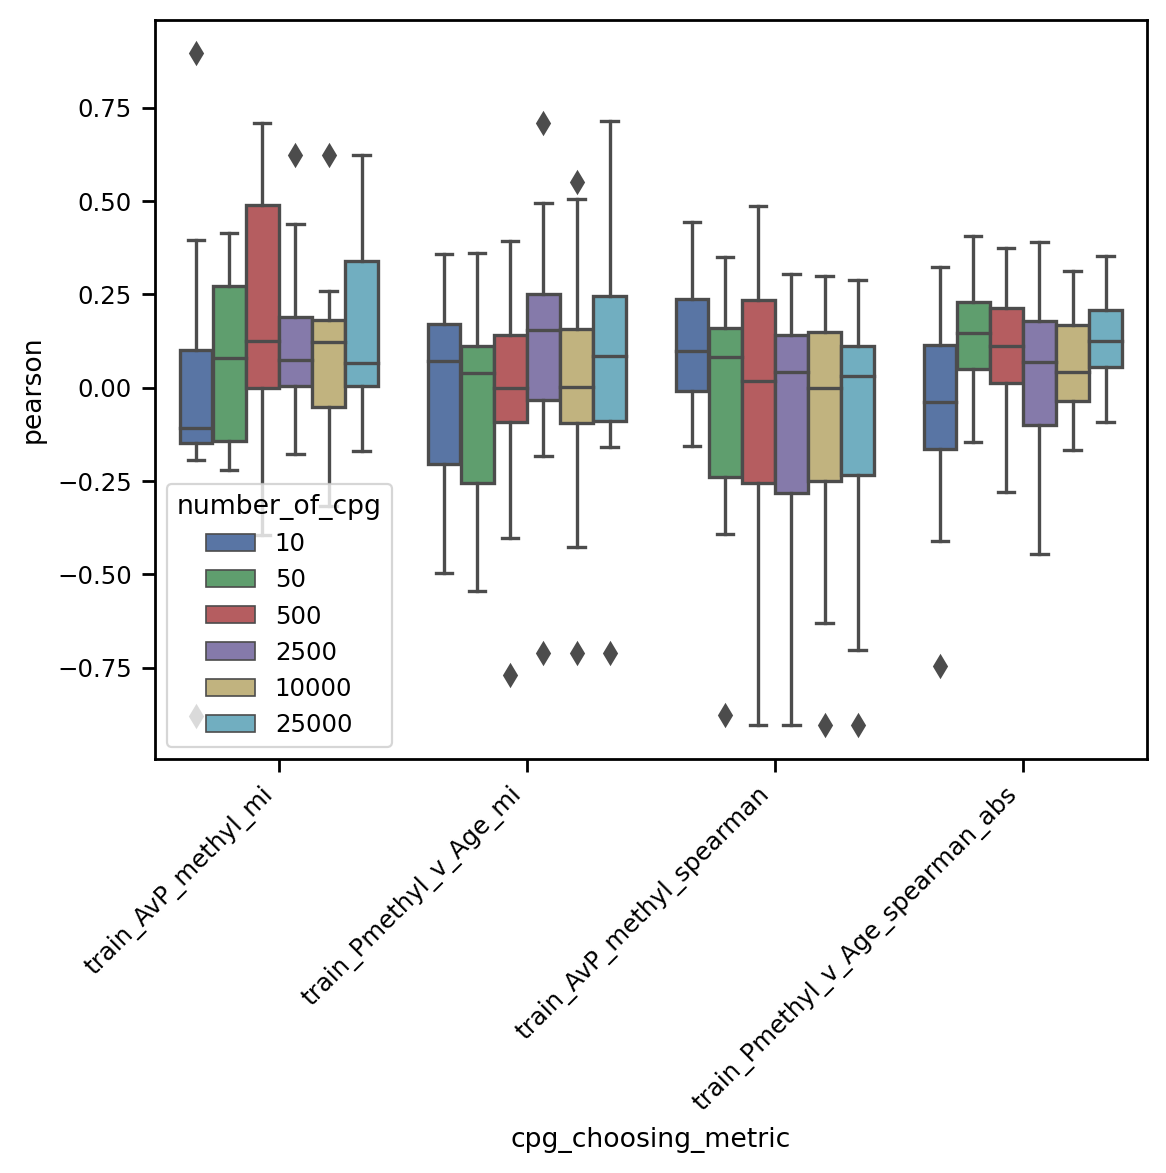

In [59]:
sns.boxplot(data = best_clock_scan_results_df_icgc_agg_only, hue = 'number_of_cpg', y = 'pearson', x = 'cpg_choosing_metric')
# angle x ticks
_ = plt.xticks(rotation=45, ha='right')

In [67]:
somage.performance_by_dataset_df['dataset'].value_counts()

PRAD    48000
PACA    48000
PBCA    48000
CLLE    48000
PAEN    48000
UTCA    48000
Name: dataset, dtype: int64

In [68]:
best_clock_scan_results_df_icgc_agg_only.query("dataset == 'PACA'").sort_values(by='pearson', ascending=False).head(3)

,dataset,cpg_choosing_metric,number_of_cpg,training_methylation_type,train_set,model_type,train_tissue,pearson,spearman,trained_clock,y_pred,y_test
52,PACA,train_AvP_methyl_spearman,500,pred,train,xgboost,self,0.398717,0.466875,"XGBRegressor(base_score=None, booster=None, ca...","[66.572945, 78.555145, 68.43725, 51.78157, 55....",sample DO49181 77 DO32851 84 DO49149 ...
67,PACA,train_Pmethyl_v_Age_spearman_abs,2500,actual,train,xgboost,self,0.390990,0.402697,"XGBRegressor(base_score=None, booster=None, ca...","[67.29234, 70.70209, 67.11442, 67.1205, 67.120...",sample DO49181 77 DO32851 84 DO49149 ...
86,PACA,train_Pmethyl_v_Age_mi,50,pred,train,xgboost,self,0.361696,0.407156,"XGBRegressor(base_score=None, booster=None, ca...","[72.50482, 64.549576, 62.138763, 55.63811, 69....",sample DO49181 77 DO32851 84 DO49149 ...


Text(0, 0.5, 'Predicted Age soMage')

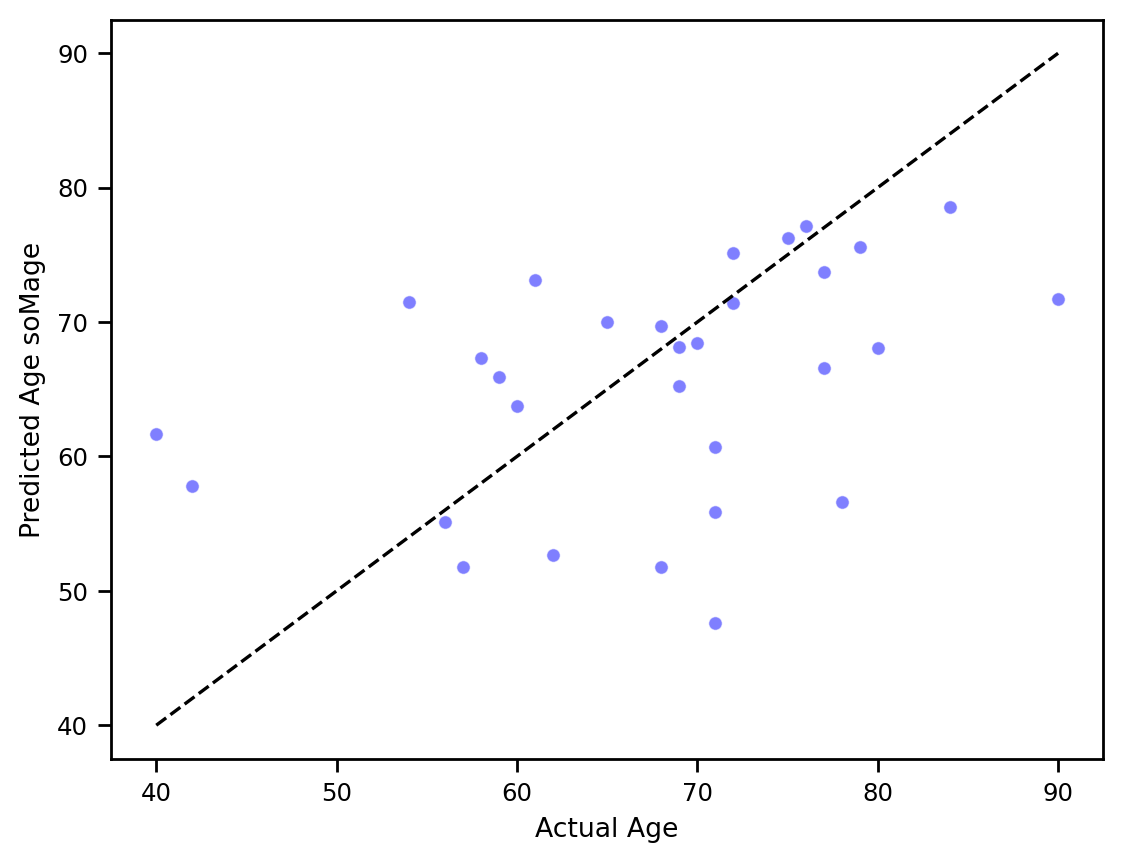

In [69]:
row_num = 52
sns.scatterplot(x = best_clock_scan_results_df_icgc_agg_only.loc[row_num, 'y_test'].values, y = best_clock_scan_results_df_icgc_agg_only.loc[row_num, 'y_pred'], color = 'blue', alpha = 0.5)
#sns.regplot(x = best_clock_scan_results_df_scrambled.loc[15, 'y_test'].values, y = best_clock_scan_results_df_actual.loc[15, 'y_pred'], color = 'red', scatter_kws={'alpha':0.5})
# add y = x line based on min and max of y_test, using axh 
plt.plot(
    [best_clock_scan_results_df_icgc_agg_only.loc[row_num, 'y_test'].values.min(), best_clock_scan_results_df_icgc_agg_only.loc[row_num, 'y_test'].values.max()],
    [best_clock_scan_results_df_icgc_agg_only.loc[row_num, 'y_test'].values.min(), best_clock_scan_results_df_icgc_agg_only.loc[row_num, 'y_test'].values.max()],
    color = 'black', linestyle = '--'
    )
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age soMage')